In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="test")
location = geolocator.geocode(u"nashville")

print(location.address)       #住所
print(location.latitude)      #緯度
print(location.longitude)     #経度
print(location.raw)           #ジオコーディングした結果の全ての情報

Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States
36.1622767
-86.7742984
{'place_id': 306134136, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 197472, 'lat': '36.1622767', 'lon': '-86.7742984', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6474694013099324, 'addresstype': 'city', 'name': 'Nashville-Davidson', 'display_name': 'Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States', 'boundingbox': ['35.9677850', '36.4054960', '-87.0547660', '-86.5155880']}


In [18]:
import unicodedata
from pathlib import Path
!pip install scikit-learn==1.3.0

import os

!pip install catboost
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install category_encoders
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import TargetEncoder

from geopy.geocoders import Nominatim
# geolocator = Nominatim()

from geopy.extra.rate_limiter import RateLimiter
import time

In [19]:
INPUT_DIR = '/content/drive/MyDrive/signate/Student Cup 2023/input'

df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,NaN,5400
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054


In [20]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sub_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "price"])

In [21]:
train_df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [22]:
test_df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1495
odometer           0
title_status     229
transmission       0
drive              0
size               0
type             229
paint_color        0
state           3029
dtype: int64

In [23]:
train_df['state'].unique()

array([nan, 'pa', 'ks', 'ny', 'ca', 'al', 'or', 'va', 'mt', 'nj', 'ma',
       'wi', 'sc', 'wa', 'dc', 'oh', 'in', 'de', 'fl', 'nm', 'az', 'ok',
       'mn', 'co', 'nv', 'wv', 'tn', 'mi', 'ri', 'il', 'tx', 'ut', 'ia',
       'ga', 'md', 'mo', 'ky', 'nc', 'ak', 'id', 'ct', 'wy', 'nd', 'me',
       'ar', 'hi', 'sd', 'ne', 'nh', 'vt', 'la', 'ms'], dtype=object)

In [24]:
# region -> stateが一意に定まることを確認
region_state = {region:{} for region in train_df['region'].unique()}
for row, value in train_df.iterrows():
    if not pd.isna(value['state']):
        if value['state'] not in region_state[value['region']]:
            region_state[value['region']][value['state']] = 1
        else:
            region_state[value['region']][value['state']] += 1

for region, state_dict in region_state.items():
    if len(state_dict) > 1 or state_dict == {}:
        region_state[region] = pd.NA
    else:
        region_state[region] = list(state_dict.keys())[0]

# regionからstateを決定
train_df['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(train_df['region'], train_df['state'])]
test_df['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(test_df['region'], test_df['state'])]

In [25]:
agg_col = ["condition", "fuel", "transmission"]
# manufacturer  paint_color v

for x in agg_col:
    grouped = train_df.groupby(x)['odometer']
    agg_data = grouped.agg(
        **{
            f"{x}_median_odometer": 'median',
            f"{x}_mean_odometer": 'mean'
        }
    ).reset_index()

    # 元のデータフレームに計算結果をマージ
    train_df = train_df.merge(agg_data, on=x, how='left')
    test_df = test_df.merge(agg_data, on=x, how='left')

In [26]:
train_df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,...,type,paint_color,state,price,condition_median_odometer,condition_mean_odometer,fuel_median_odometer,fuel_mean_odometer,transmission_median_odometer,transmission_mean_odometer
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,...,convertible,orange,tn,27587,106935.0,110741.941258,111788.5,116586.508961,121557.5,125686.500000
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,...,sedan,silver,pa,4724,147174.0,153475.427205,111788.5,116586.508961,109269.0,113500.068888
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,...,SUV,silver,ks,10931,126397.0,127622.489100,111788.5,116586.508961,109269.0,113500.068888
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,...,SUV,blue,ny,16553,106935.0,110741.941258,111788.5,116586.508961,121557.5,125686.500000
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,...,sedan,red,ca,5158,106935.0,110741.941258,111788.5,116586.508961,121557.5,125686.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,...,truck,black,pa,32212,126397.0,127622.489100,111788.5,116586.508961,109269.0,113500.068888
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,...,pickup,black,ok,5400,106935.0,110741.941258,111788.5,116586.508961,109269.0,113500.068888
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,...,SUV,white,ny,22227,92054.0,95643.998688,111788.5,116586.508961,109269.0,113500.068888
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,...,sedan,white,ny,3054,106935.0,110741.941258,111788.5,116586.508961,109269.0,113500.068888


In [27]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    # X["title_status"] = X["title_status"].fillna("clean")

    # cylinderから数値を取り出す
    X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")
    # X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").fillna(0).astype("float32")


    # sizeの表記揺れを修正
    X["size"] = X["size"].str.replace("ー", "-").astype(str)
    X["size"] = X["size"].str.replace("−", "-").astype(str)

    # 順位付け: サイズ別に値を割り当てます。大きいほど高い値にします。
    ranking_dict = {'full-size': 4, 'mid-size': 3, 'compact': 2, 'sub-compact': 1}

    # 新しい順位カラムを作成します。
    X['size_rank'] = X['size'].map(ranking_dict)

    # manufacturerの表記揺れを修正
    X["manufacturer"] = X["manufacturer"].apply(
        lambda x: unicodedata.normalize("NFKC", x).lower()
    )

    # 正規化の辞書
    normalize_dict = {
        'niѕsan': 'nissan',
        'subαru': 'subaru',
        'toyotа': 'toyota',
        'sαturn': 'saturn',
        'аcura': 'acura',
        'vоlkswagen': 'volkswagen',
        'lexuѕ': 'lexus',
        'ᴄhrysler': 'chrysler'
    }


    # データフレームのメーカー名を正規化
    X['manufacturer'] = X['manufacturer'].map(lambda x: normalize_dict.get(x, x))

    # 国別分類
    def classify_country(manufacturer):
        if pd.isnull(manufacturer):
            return 'Unknown'
        if manufacturer in ['bmw', 'volkswagen', 'audi', 'mercedes-benz', 'porsche']:
            return 'Germany'
        elif manufacturer in ['toyota', 'nissan', 'lexus', 'subaru', 'honda', 'mazda', 'mitsubishi', 'infiniti', 'acura']:
            return 'Japan'
        elif manufacturer in ['ford', 'buick', 'ram', 'dodge', 'chevrolet', 'jeep', 'chrysler', 'gmc', 'lincoln', 'cadillac', 'pontiac', 'saturn']:
            return 'USA'
        elif manufacturer in ['hyundai', 'kia']:
            return 'South Korea'
        elif manufacturer in ['fiat', 'alfa-romeo']:
            return 'Italy'
        elif manufacturer in ['land rover', 'jaguar', 'aston-martin', 'rover']:
            return 'UK'
        else:
            return 'Unknown'

    X['country'] = X['manufacturer'].apply(classify_country)


    def classify_color(color):
        if color in ['orange', 'yellow', 'red', 'white']:
            return 'Bright'
        elif color in ['black', 'brown', 'green', 'blue']:
            return 'Dark'
        elif color in ['silver', 'grey']:
            return 'Neutral'
        elif color in ['purple', 'custom']:
            return 'Special'
        else:
            return 'Unknown'

    X['color_category'] = X['paint_color'].apply(classify_color)

    # one-hot encoding
    # X = pd.get_dummies(X, columns=['country'])

    # yearが3000年以降のものはおかしいので2000年に置換
    err_idx = X.query("year >= 3000").index
    X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

    # 走行距離 / 製造年
    X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

    for col in agg_col:
      X[f"{col}_diff_mean"] = X["odometer"] - X[f"{x}_mean_odometer"]
      X[f"{col}_diff_median"] = X["odometer"] - X[f"{x}_median_odometer"]

    # X["pass_year"] = 2023 - X["year"]

    # X['state'] = X['state'].replace('<NA>', 'null')
    # X.dropna(subset=['state'], inplace=True)
    X['state'] = X['state'].fillna("unknown")

    err_idx = X.query("odometer < -1").index
    X.loc[err_idx, "odometer"] = X.loc[err_idx, "odometer"].apply(lambda x: -1)

    # Geolocatorオブジェクトを作成
    geolocator = Nominatim(user_agent="gabikueh")

    # ユニークなregionを取得
    unique_regions = X['region'].unique()

    # 緯度経度の辞書を作成
    # lat_lon_dict = {}

    # for city in unique_regions:
    #     try:
    #         location = geolocator.geocode(city)
    #         if location:
    #             lat_lon_dict[city] = {'latitude': location.latitude, 'longitude': location.longitude}
    #             print(location.raw)  # ジオコーディングした結果の全ての情報
    #         else:
    #             lat_lon_dict[city] = {'latitude': None, 'longitude': None}
    #             print(f"Failed to geocode for city: {city}")
    #     except Exception as e:
    #         lat_lon_dict[city] = {'latitude': None, 'longitude': None}
    #         print(f"Error geocoding city: {city}. Error message: {e}")

    # # ユニークな地域の緯度経度を元のデータフレームにマージ
    # geo_df = pd.DataFrame.from_dict(lat_lon_dict, orient='index').reset_index().rename(columns={'index': 'region'})
    # X = X.merge(geo_df, on='region', how='left')

    return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols

class CountTransformer(TransformerMixin, BaseEstimator):
    """CountEncoder"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.ce = CountEncoder(cols=X.columns.tolist(), handle_unknown=0)
        self.ce.fit(X)
        return self

    def transform(self, X):
        return self.ce.transform(X)

    def get_feature_names_out(self, input_features=None):
        return input_features


class AggTransformer(TransformerMixin, BaseEstimator):
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict):
        self.key = key
        self.numeric_cols = numeric_cols
        self.agg_func = agg_func

    def fit(self, X, y=None):
        X = X.copy()
        X[self.key] = X[self.key].astype("category")
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

        return self

    def transform(self, X):
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.tolist()

In [29]:
result_agg_cols = [f"{x}_diff_{stat}" for x in agg_col for stat in ['mean', 'median']]
numeric_cols = ["year", "odometer", "odometer_per_year", "size_rank",
                # "latitude", "longitude"
                ] + result_agg_cols
categorical_cols = [
    'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
    "country",
    "color_category"
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            categorical_cols,
        ),
        (
            "cnt",
            CountTransformer(),
            categorical_cols,
        ),
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)


[ColumnTransformer] ........... (1 of 3) Processing ori, total=   0.1s
[ColumnTransformer] ........... (2 of 3) Processing tgt, total=   0.3s
[ColumnTransformer] ........... (3 of 3) Processing cnt, total=   1.1s


In [30]:
train_feat_df.to_csv(os.path.join(INPUT_DIR, "train_feat_df.csv"))

In [38]:
train_feat_df.head()

,ori__year,ori__odometer,ori__odometer_per_year,ori__size_rank,ori__condition_diff_mean,ori__condition_diff_median,ori__fuel_diff_mean,ori__fuel_diff_median,ori__transmission_diff_mean,ori__transmission_diff_median,...,cnt__fuel,cnt__title_status,cnt__transmission,cnt__drive,cnt__size,cnt__type,cnt__paint_color,cnt__state,cnt__country,cnt__color_category
0,1949.0,115148.0,1556.054077,3.0,-10538.500000,-6409.5,-10538.500000,-6409.5,-10538.500000,-6409.5,...,23546,22365,6156,4834,9411,418,144,689,4357,5217
1,2013.0,172038.0,17203.800781,4.0,58537.929688,62769.0,58537.929688,62769.0,58537.929688,62769.0,...,23546,22365,20497,4834,14636,9259,4300,1107,5835,5436
2,1998.0,152492.0,6099.680176,4.0,38991.929688,43223.0,38991.929688,43223.0,38991.929688,43223.0,...,23546,22365,20497,14602,14636,7311,4300,293,15947,5436
3,2014.0,104118.0,11568.666992,3.0,-21568.500000,-17439.5,-21568.500000,-17439.5,-21568.500000,-17439.5,...,23546,22365,6156,14602,9411,7311,3765,2112,15947,16658
4,2005.0,144554.0,8030.777832,3.0,18867.500000,22996.5,18867.500000,22996.5,18867.500000,22996.5,...,23546,22365,6156,14602,9411,9259,1419,3050,15947,5217


In [39]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(1000, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train,
            y_train,
            cat_features=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=verbose,
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# optunaを使ったパラメータチューニング
# def tuning(train_feat_df, train_df, cv):
#     def objective(trial):
#         max_depth = trial.suggest_int("max_depth", 1, 10)
#         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
#         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
#         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

#         params = {
#             "objective": "mape",
#             "n_estimators": 10000,
#             "learning_rate": 0.05,
#             "max_depth": max_depth,
#             "num_leaves": num_leaves,
#             "colsample_bytree": colsample_bytree,
#             "subsample": subsample,
#             "metric": "mape",
#             "importance_type": "gain",
#             "random_state": 88,
#         }

#         score, _, _ = fit_lgbm(
#             train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
#         )
#         return score

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)
#     print("Number of finished trials:", len(study.trials))
#     print("Best trial:", study.best_trial.params)
#     return study.best_trial.params


def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax

In [40]:
n_fold = 5
catboost_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 64,
    "colsample_bytree": 0.446,
    "subsample": 0.339,
    "importance_type": "gain",
    "random_state": 88,
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

# training
score, oof, models = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=catboost_params,
    cv=cv,
    verbose=False,
)

# inference
pred = np.array([model.predict(test_feat_df).squeeze() for model in models])
pred = np.mean(pred, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv("submission-027.csv", index=False, header=False)

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

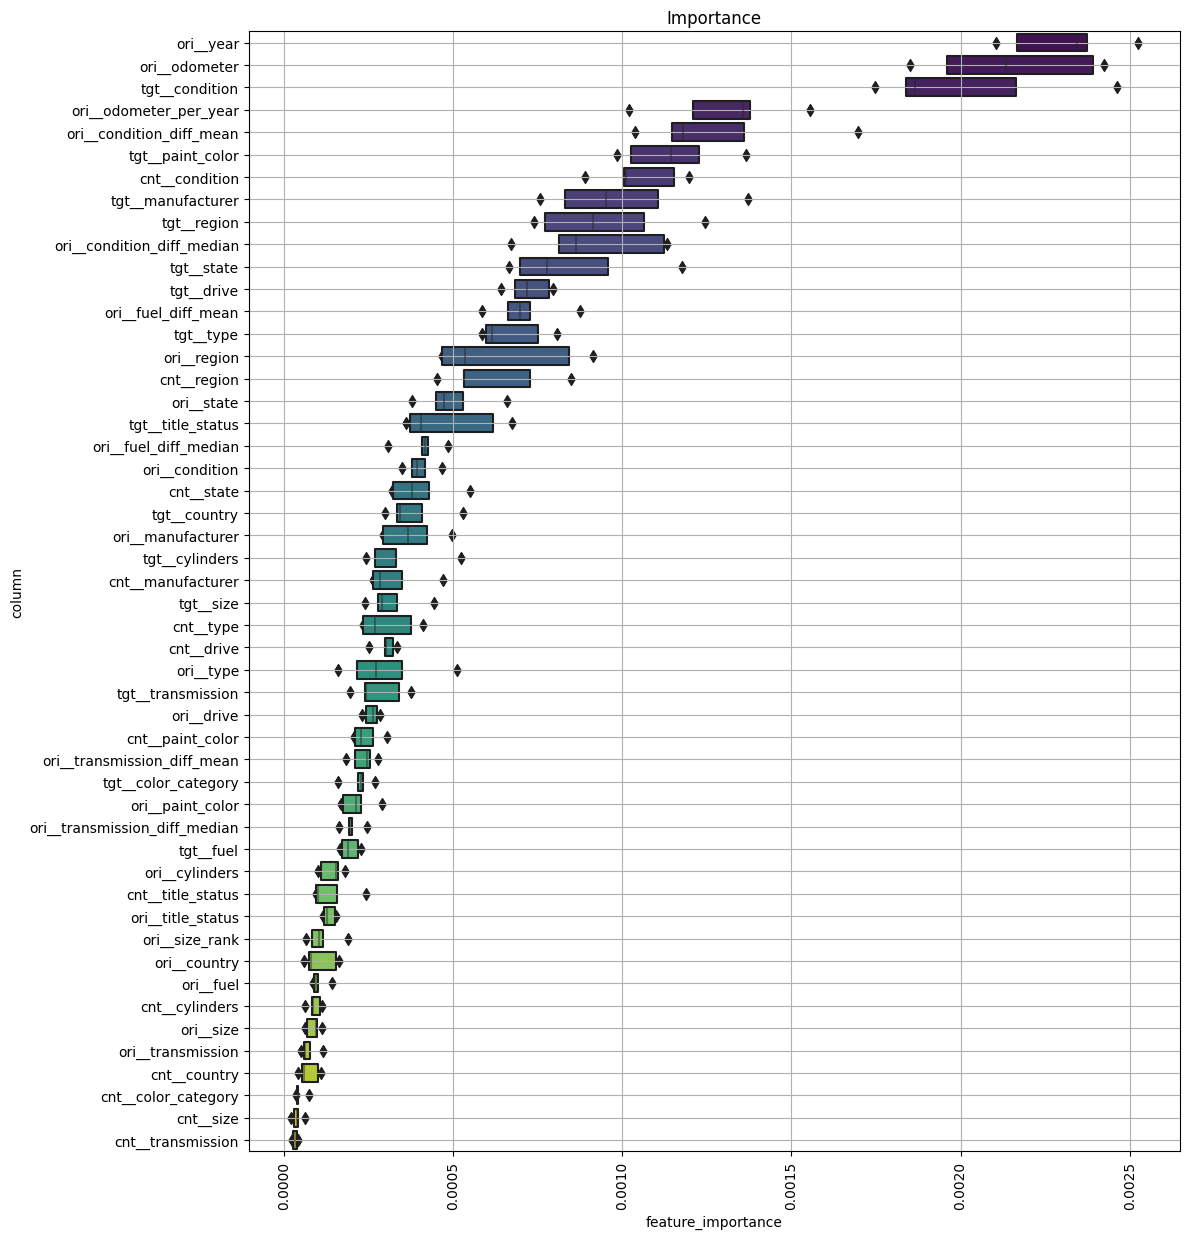

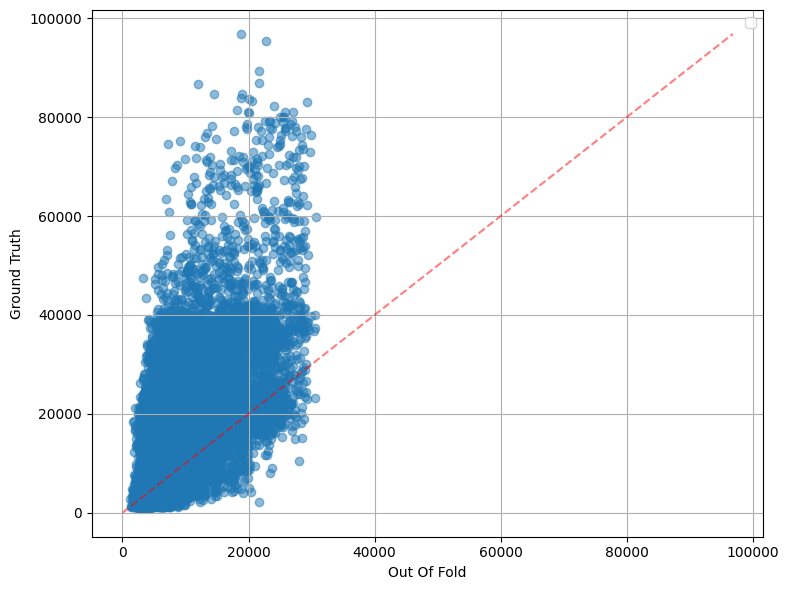

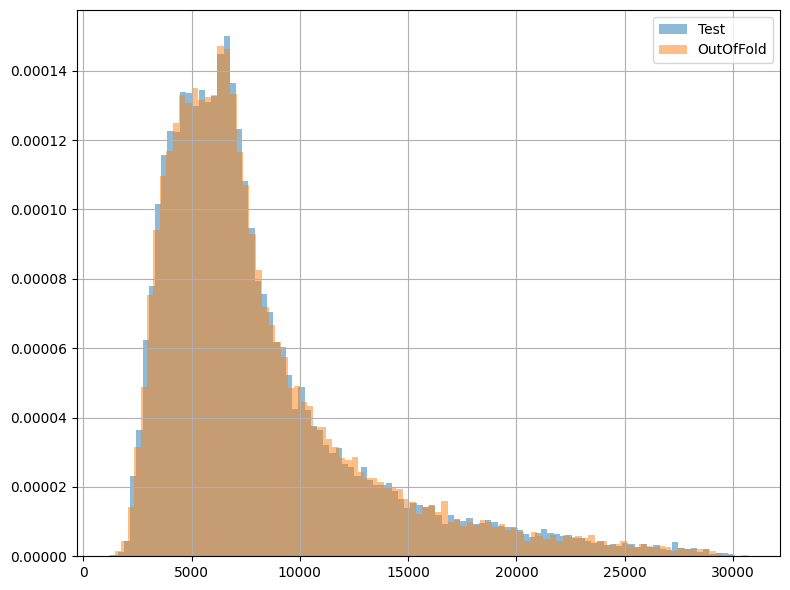

In [41]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)